# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tifffile as tiff

## Load test features

In [106]:
# DATOS_train
datos_test = pd.read_csv("data/DATOS_test.csv")
datos_test.head()
datos_test.shape

(1329, 2)

In [3]:
path_feats = "data/test_features/content/test_features/"

In [4]:
feats = []
for n in range(len(datos_test)):
    path_feat = datos_test.iloc[n].feature_image
    feat = tiff.imread(path_feats + path_feat)
    
    feats.append(feat)
    
feats = np.array(feats)

In [5]:
feats.shape

(1329, 128, 128, 10)

In [6]:
feats.min(), feats.max()

(-3.4028235e+38, 1.0)

## Prepocess Features

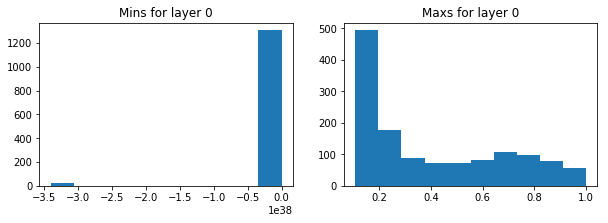

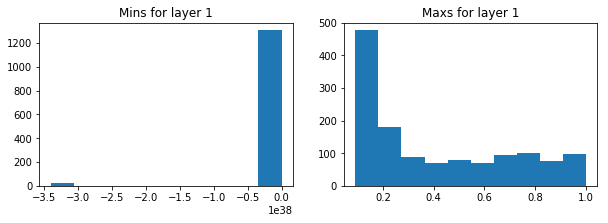

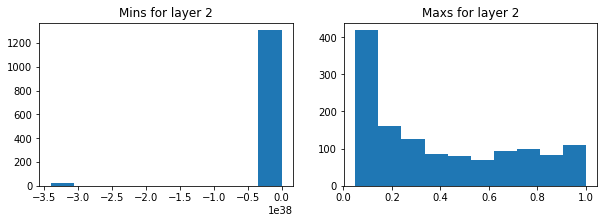

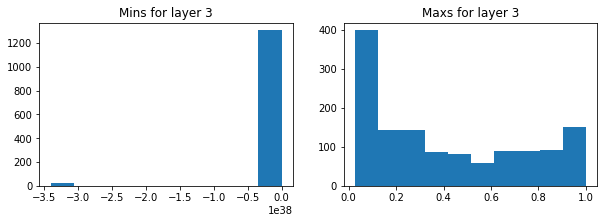

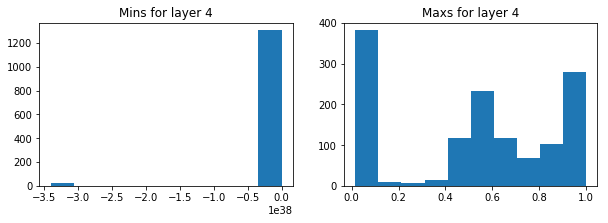

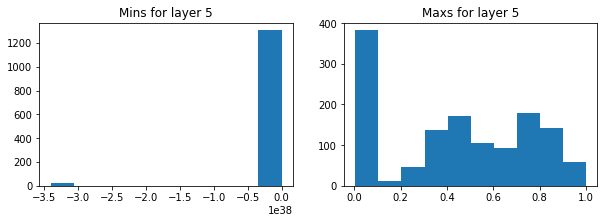

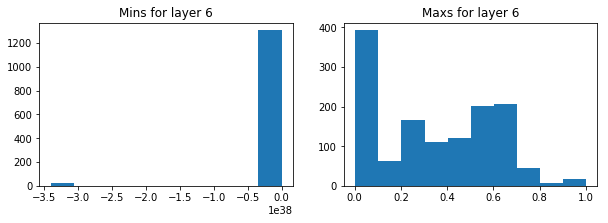

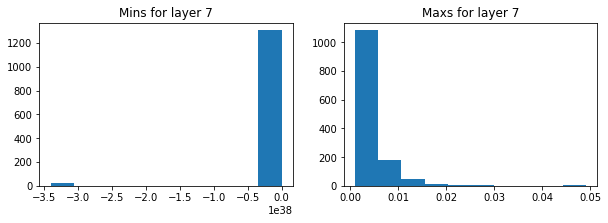

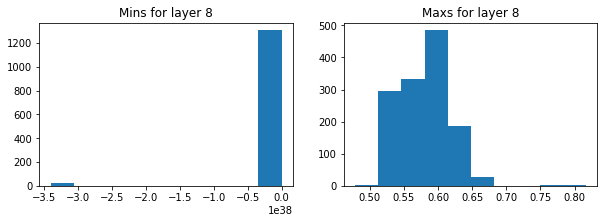

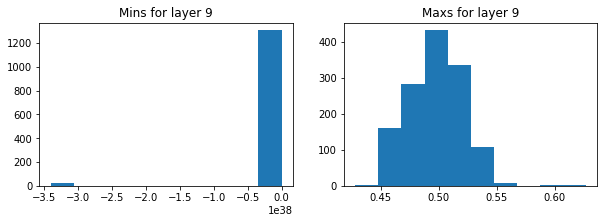

In [7]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats.shape[0]):
        vals = feats[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

In [8]:
# which have minimum values < - 1?
outliers = []
for i in feats:
    if np.min(i) < -1:
        outliers.append(i)

In [9]:
len(outliers)

24

In [10]:
# we trim outlier values to 0
feats_final = np.clip(feats, -1, 1)

In [11]:
feats_final.shape

(1329, 128, 128, 10)

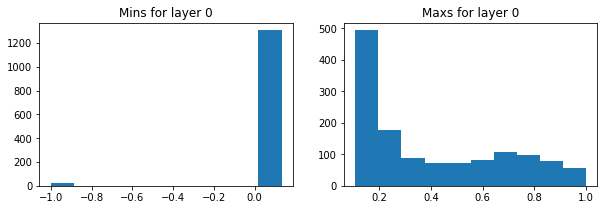

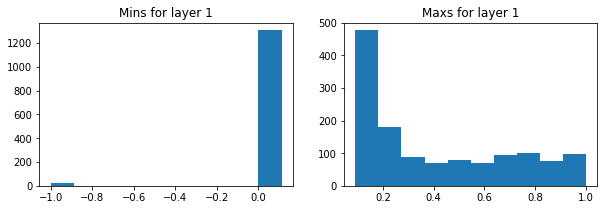

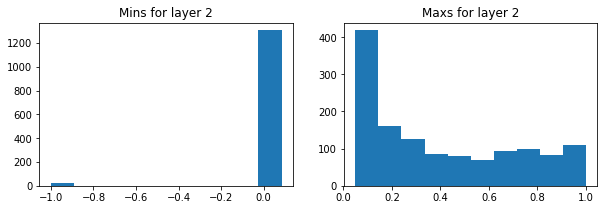

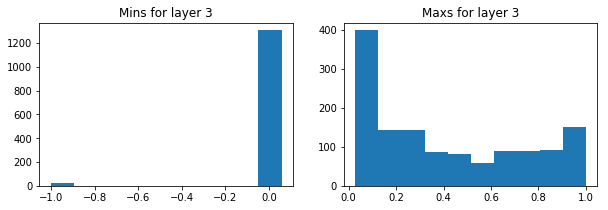

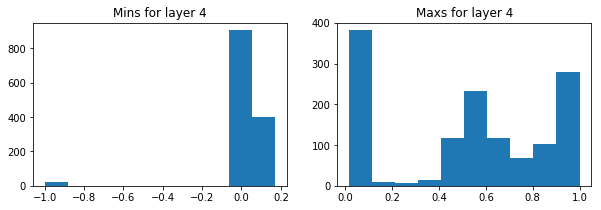

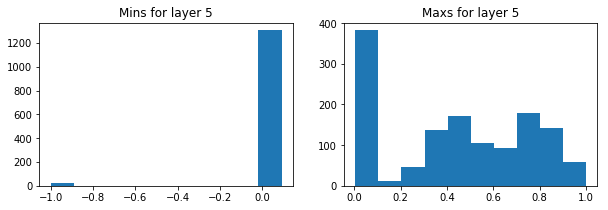

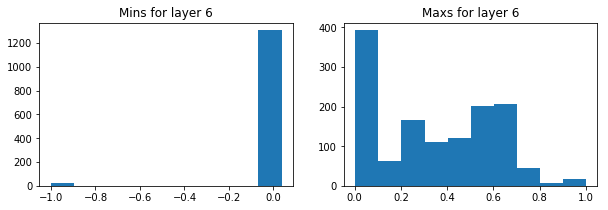

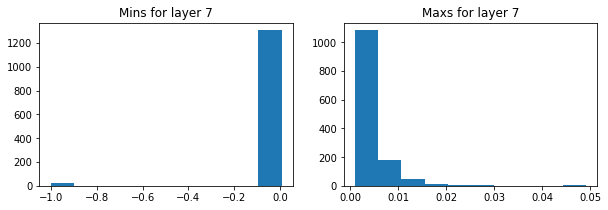

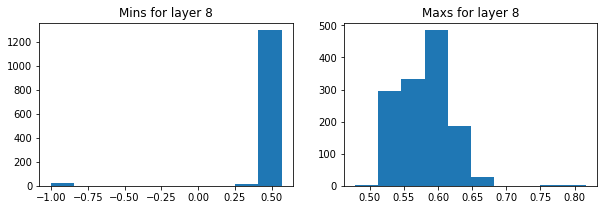

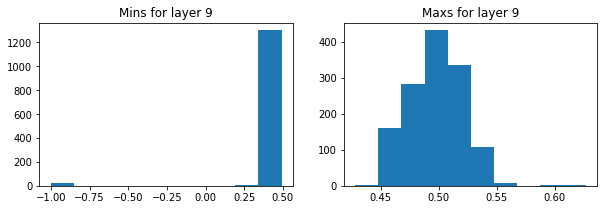

In [12]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats_final.shape[0]):
        vals = feats_final[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

In [204]:
## Compress labels

def compress_label(matrix):
    classes = [0, 1, 2, 4, 5, 6, 7, 15]

    new_array = []
    for i in range(8):
        layer = matrix[:, :, i]
        layer = np.round(layer) * classes[i]
        new_array.append(layer)
    
    new_array = np.array(new_array)
    new_array = np.swapaxes(new_array, 0, 2)
    new_array = np.max(new_array, axis=2)
    new_array = np.rot90(new_array, k=-1)
    new_array = np.fliplr(new_array)
    
    return new_array.astype(int)

# Test Prediction

In [157]:
from tensorflow.keras.models import load_model

In [17]:
unet_model = load_model('models/datos_unet_gen_sigmoid_2019_11_16_0.h5')

In [205]:
test_preds = unet_model.predict(feats_final)
test_preds.shape

(1329, 128, 128, 8)

In [206]:
test_preds2 = np.array([compress_label(i) for i in test_preds])

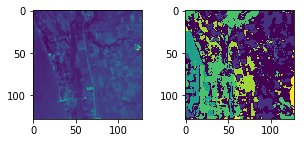

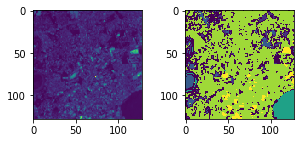

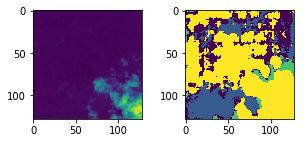

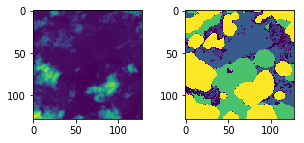

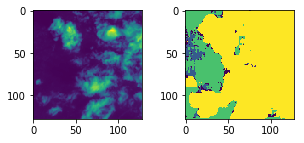

In [208]:
# predict
for i in np.random.choice(list(range(len(feats_final))), 5):

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))

    test_feat = feats_final[i]

    # show one input
    axs[0].imshow(test_feat[:, :, 0])

    # predict sample with values from 0 to 1
    test_pred = test_preds2[i]

    axs[1].imshow(test_pred)

    plt.show()

## Submission File

In [209]:
# sample submission file
sample_sub = pd.read_csv("data/sample_submission_file.csv")
sample_sub.head()

,indexId,EncodedPixel_Pred
0,4230-20,NaN
1,4230-1,NaN
2,4230-2,NaN
3,4230-4,2 16382
4,4230-5,NaN


In [210]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode(mask):
    pixels = mask.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return rle_to_string(runs)

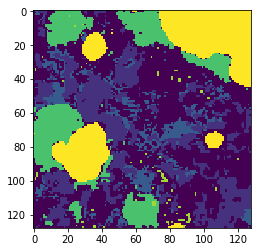

In [211]:
plt.imshow(test_preds2[3])

In [212]:
i = 3
encode = rle_to_string(rle_encode(test_preds2[i]))
encode

'2   2   9   5   2 9   2   3 3   4   4 4   7   5 4   1   5 8   1   6 2   4   7 5   5 4   1 3 1   1   1 3 7   5   1 5 7   2   1 6 1   4   1 7 2   6   1 8 6   3   2 0 2   1   2 5 7   1   2 6 1   2   2 6 5   3   2 8 6   2   2 8 9   4   2 9 5   1 1   3 3 1   5 4   3 9 1   1   3 9 5   1 1   4 0 7   8   4 2 2   1   4 2 7   1   4 3 5   2 4   5 1 3   5   5 1 9   1   5 2 2   2 2   5 4 5   3   5 6 3   2 4   6 4 1   4   6 4 6   1   6 4 8   2   6 7 6   1   6 8 3   1   6 9 2   2 3   7 1 6   5 3   7 7 2   1   7 7 4   2   7 7 9   2 5   8 1 1   1   8 2 1   2 3   8 9 7   3   9 0 1   1   9 0 4   4   9 3 2   3   9 3 6   3   9 4 1   1   9 4 9   2 3   1 0 2 5   5   1 0 3 1   1   1 0 5 4   1   1 0 5 6   4   1 0 6 5   1   1 0 7 8   1   1 0 8 0   2 0   1 1 5 3   7   1 1 7 7   1   1 1 8 8   6   1 1 9 5   1   1 2 0 7   2 1   1 2 8 1   3   1 2 8 7   2   1 3 1 2   1   1 3 1 5   1 8   1 3 3 5   2 1   1 3 5 7   5 2   1 4 1 2   3   1 4 1 6   2   1 4 3 9   3   1 4 4 3   1 2   1 4 5 6   4   1 4 6 3   1   1 4 8 5   5 2

In [213]:
ids = datos_test.iloc[:, 0].values
ids

array([5106, 1859, 2430, ..., 1660, 1392, 2992])

In [166]:
len(ids)

1329

In [214]:
from collections import Counter

Counter(test_preds2.flatten())

Counter({4: 7857083,
         0: 2445160,
         5: 1494243,
         6: 160964,
         2: 6557059,
         1: 587811,
         7: 2672016})

In [230]:
Counter(test_preds2[1].flatten())

Counter({4: 9658, 0: 1656, 5: 89, 6: 150, 2: 4811, 1: 20})

In [234]:
ids[1]

1859

In [243]:
# Define a dictionary containing employee data
data = {'indexId':[],
        'EncodedPixel_RLE_Pred':[]}
  
df_solution=pd.DataFrame(data)

labels = [0, 1,  2,  4,  5,  6,  7, 15]

for i in range(len(test_preds2)):
    for label in labels:
        id_ = ids[i]
        layer = test_preds2[i] == label
        layer = layer.astype(int)
        rle = rle_encode(layer)
        if label == 0:
            data['indexId'] += [f'{id_}-20']
            data['EncodedPixel_RLE_Pred'] += [rle]
        else:
            data['indexId'] += [f'{id_}-{label}']
            data['EncodedPixel_RLE_Pred'] += [rle]

In [256]:
a = test_preds2[1] == 0
a = a.astype(int)

i = 74
j = 4
a.flatten()[i-1:i-1+j]

array([0, 1, 0, 0])

In [245]:
submission = pd.DataFrame.from_dict(data)

In [246]:
submission.head(50)

,indexId,EncodedPixel_RLE_Pred
0,5106-20,
1,5106-1,
2,5106-2,
3,5106-4,2 16382
4,5106-5,
5,5106-6,
6,5106-7,
7,5106-15,
8,1859-20,72 2 75 1 115 1 127 2 256 1 379 2 619 2 747 2 ...
9,1859-1,3445 1 3583 1 4095 2 12618 2 12746 1 12870 1 1...


In [247]:
submission.to_csv('submission.csv', index=False)

In [248]:
len(submission.indexId.values)/8

1329.0

In [249]:
pd.read_csv('submission.csv')

,indexId,EncodedPixel_RLE_Pred
0,5106-20,NaN
1,5106-1,NaN
2,5106-2,NaN
3,5106-4,2 16382
4,5106-5,NaN
5,5106-6,NaN
6,5106-7,NaN
7,5106-15,NaN
8,1859-20,72 2 75 1 115 1 127 2 256 1 379 2 619 2 747 2 ...
9,1859-1,3445 1 3583 1 4095 2 12618 2 12746 1 12870 1 1...
